Imports

In [1]:
# Cell 1: Imports
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from tools import BouncingBallSim, TransitionNet, generate_balanced_training_data, animate_trajectories, StructuredTransitionNet, compare_models,KVAE, generate_trajectory_data

In [2]:
debug_sim = BouncingBallSim()
# Force a start near a wall to guarantee we see a bounce immediately
""" debug_sim.pos = np.array([30.0, 15.0]) 
debug_sim.vel = np.array([0., 0.]) """

print("Generating diagnostic sequence...")
# We grab 100 frames to verify the physics
vis_data = [debug_sim.step() for _ in range(80)] 
vis_truth = np.array([d[2] for d in vis_data]) # Extract Ground Truth (x, y)

# 2. Animate
# We pass 'vis_truth' as both ground_truth and estimates just to hack the 
# visualizer into showing a single colored line
anim = animate_trajectories(
    ground_truth=vis_truth, 
    estimates=None, 
    labels=["Training Physics"]
)

print("Check this video: Does the ball BOUNCE or stick to the wall?")
display(anim)

Generating diagnostic sequence...
Check this video: Does the ball BOUNCE or stick to the wall?


Train the Deep Model

Using Device: cpu
Generating Training Data...
Starting training...
Epoch 0: Train Loss 194.84903, Val Loss 193.21921
Epoch 50: Train Loss 26.34665, Val Loss 25.49631
Epoch 100: Train Loss 17.21382, Val Loss 16.65746
Epoch 150: Train Loss 0.47654, Val Loss 0.46678
Epoch 200: Train Loss 0.17254, Val Loss 0.17262
Epoch 250: Train Loss 0.12996, Val Loss 0.13229
Epoch 300: Train Loss 0.11497, Val Loss 0.11741
Epoch 350: Train Loss 0.10688, Val Loss 0.10960
Epoch 400: Train Loss 0.10136, Val Loss 0.10458
Epoch 450: Train Loss 0.09694, Val Loss 0.10041
Epoch 500: Train Loss 0.09319, Val Loss 0.09680
Epoch 550: Train Loss 0.09047, Val Loss 0.09439
Epoch 600: Train Loss 0.08697, Val Loss 0.09113
Epoch 650: Train Loss 0.08407, Val Loss 0.08853
Epoch 700: Train Loss 0.08122, Val Loss 0.08602
Epoch 750: Train Loss 0.07883, Val Loss 0.08416
Epoch 800: Train Loss 0.07626, Val Loss 0.08166
Epoch 850: Train Loss 0.07391, Val Loss 0.07941
Epoch 900: Train Loss 0.07509, Val Loss 0.08197
Epoch 950: Train

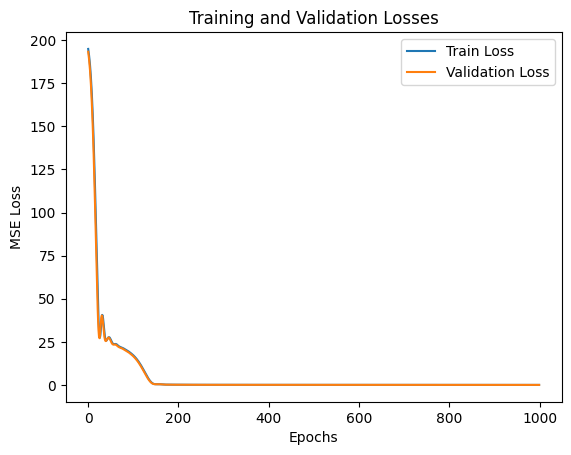

In [3]:
# --- STEP 1: TRAIN THE DEEP MODEL (GPU OPTIMIZED) ---

# 1. SETUP DEVICE
# Check if GPU is available (CUDA for NVIDIA, MPS for Mac M1/M2)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using Device: {device}")

# 2. PREPARE DATA
print("Generating Training Data...")
train_x, train_y = generate_balanced_training_data(n_samples=20000)
val_x, val_y = generate_balanced_training_data(n_samples=2000) 

# --- CRITICAL CHANGE 1: Move Data to GPU ---
# We move the entire dataset to GPU memory once (since it's small enough)
# This is much faster than moving small batches inside the loop.
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x = val_x.to(device)
val_y = val_y.to(device)

# 3. SETUP MODEL
dkf = TransitionNet()
# --- CRITICAL CHANGE 2: Move Model to GPU ---
dkf.to(device) 

optimizer = optim.Adam(dkf.parameters(), lr=0.005)
criterion = nn.MSELoss()

# 4. TRAINING LOOP
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1000):
    dkf.train() 
    optimizer.zero_grad()
    
    # Everything happens on GPU now because model & data are there
    predictions = dkf(train_x) 
    loss = criterion(predictions, train_y)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    dkf.eval()
    with torch.no_grad():
        val_predictions = dkf(val_x)
        val_loss = criterion(val_predictions, val_y)
        val_losses.append(val_loss.item())
        
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.5f}, Val Loss {val_loss.item():.5f}")
    if val_loss.item() > train_losses[-1] * 1.5:
        print("Early stopping due to overfitting.")
        break

# 5. PLOT LOSSES
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

Using Device: cpu
Generating Training Data (Sequences)...
Starting training for 200 epochs...
Epoch 0: Loss 161181.2722 | Val 87181.7188 | Recon 87080.87
Epoch 10: Loss 2494.4481 | Val 1160.4421 | Recon 862.14
Epoch 20: Loss 690.4685 | Val 920.3833 | Recon 655.78
Epoch 30: Loss 1417.1415 | Val 1330.7043 | Recon 1102.54
Epoch 40: Loss 549.0059 | Val 424.0931 | Recon 196.16
Epoch 50: Loss 473.1023 | Val 409.7203 | Recon 187.31
Epoch 60: Loss 410.6720 | Val 470.0092 | Recon 247.98
Epoch 70: Loss 416.6976 | Val 457.2317 | Recon 241.74
Epoch 80: Loss 392.8294 | Val 274.1400 | Recon 56.04
Epoch 90: Loss 395.6234 | Val 337.8794 | Recon 124.20
Epoch 100: Loss 580.3217 | Val 698.5472 | Recon 478.94
Epoch 110: Loss 382.5121 | Val 408.5953 | Recon 193.85
Epoch 120: Loss 362.6572 | Val 406.4963 | Recon 194.24
Epoch 130: Loss 433.4877 | Val 369.4173 | Recon 154.80
Epoch 140: Loss 351.1371 | Val 356.0219 | Recon 142.53
Epoch 150: Loss 441.3329 | Val 509.7087 | Recon 286.04
Epoch 160: Loss 845.1193 |

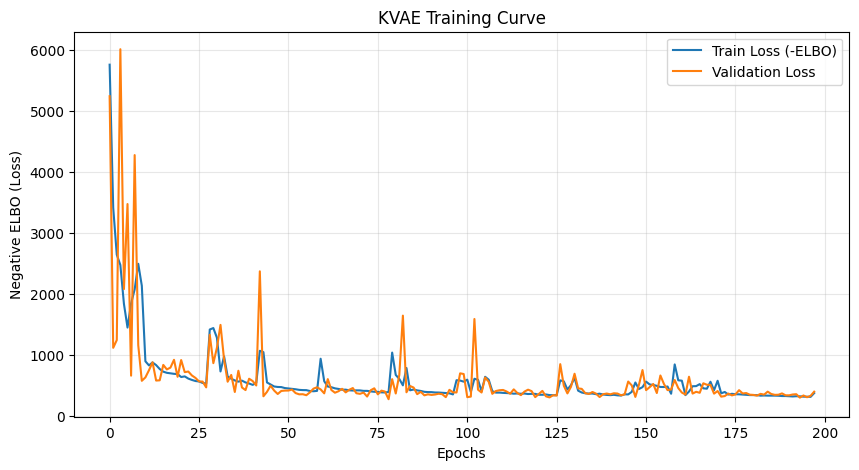

In [11]:
 #KVAE model

# 1. SETUP DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using Device: {device}")

# 2. PREPARE DATA
print("Generating Training Data (Sequences)...")
# KVAE needs full trajectories (e.g. T=40 steps), not just transition pairs.
# We generate fewer samples than before (2000 vs 20000) because each sample is a sequence of 40 points.
train_x = generate_trajectory_data(n_sequences=2000, T=40)
val_x = generate_trajectory_data(n_sequences=200, T=40)

# Move Data to GPU
train_x = train_x.to(device)
val_x = val_x.to(device)

# 3. SETUP MODEL
# x_dim=2 (input coords), a_dim=2 (latent object), z_dim=4 (dynamics state pos+vel), K=3 experts
model = KVAE(x_dim=2, a_dim=2, z_dim=4, K=3, hidden_dim=64)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

# 4. TRAINING LOOP
train_losses = []
val_losses = []
n_epochs = 200
batch_size = 64 # Important: Process in batches to avoid GPU OOM with LSTM/Kalman

print(f"Starting training for {n_epochs} epochs...")

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    n_batches = 0
    
    # Shuffle Data
    perm = torch.randperm(train_x.size(0))
    
    # Mini-batch loop
    for i in range(0, train_x.size(0), batch_size):
        idx = perm[i : i + batch_size]
        batch = train_x[idx]
        
        optimizer.zero_grad()
        
        # KVAE forward returns (total_loss, recon_loss, dynamics_loss)
        loss, recon, dyn = model(batch)
        
        loss.backward()
        
        # Gradient Clipping (Critical for KVAE stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1

    avg_train_loss = epoch_loss / n_batches
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        # Process validation in one go (or batch if memory fails)
        v_loss, v_recon, v_dyn = model(val_x)
        val_losses.append(v_loss.item())
        
    if epoch % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch}: Loss {avg_train_loss:.4f} | Val {v_loss.item():.4f} | Recon {v_recon.item():.2f}")

# 5. PLOT LOSSES
plt.figure(figsize=(10,5))
plt.plot(train_losses[2:], label="Train Loss (-ELBO)")
plt.plot(val_losses[2:], label="Validation Loss")
plt.title("KVAE Training Curve")
plt.xlabel("Epochs")
plt.ylabel("Negative ELBO (Loss)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Using Device: cpu
Generating Training Data...
Starting training...
Epoch 0: Train Loss 0.16506, Val Loss 0.15257
Epoch 50: Train Loss 0.06932, Val Loss 0.06573
Epoch 100: Train Loss 0.02862, Val Loss 0.02600
Epoch 150: Train Loss 0.01936, Val Loss 0.01799
Epoch 200: Train Loss 0.01697, Val Loss 0.01578
Epoch 250: Train Loss 0.01580, Val Loss 0.01479
Epoch 300: Train Loss 0.01539, Val Loss 0.01446
Epoch 350: Train Loss 0.01493, Val Loss 0.01404
Epoch 400: Train Loss 0.01449, Val Loss 0.01367
Epoch 450: Train Loss 0.01388, Val Loss 0.01311
Epoch 500: Train Loss 0.01355, Val Loss 0.01320
Epoch 550: Train Loss 0.01308, Val Loss 0.01191
Epoch 600: Train Loss 0.01188, Val Loss 0.01124
Epoch 650: Train Loss 0.01134, Val Loss 0.01068
Epoch 700: Train Loss 0.01090, Val Loss 0.01030
Epoch 750: Train Loss 0.01002, Val Loss 0.00958
Epoch 800: Train Loss 0.00962, Val Loss 0.00925
Epoch 850: Train Loss 0.00911, Val Loss 0.00882
Epoch 900: Train Loss 0.00888, Val Loss 0.00854
Epoch 950: Train Loss 0.

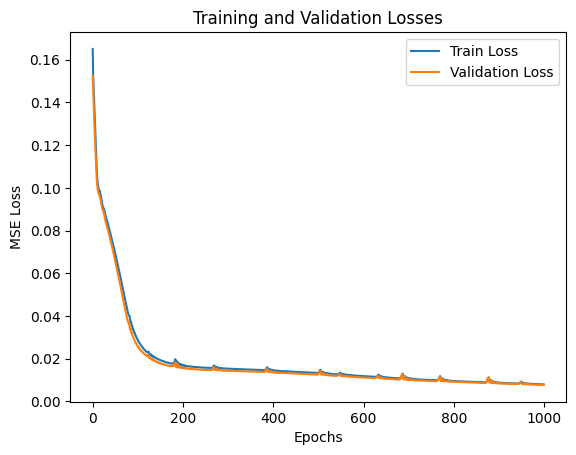

In [ ]:
# --- STEP 1: TRAIN THE DEEP MODEL (GPU OPTIMIZED) ---

# 1. SETUP DEVICE
# Check if GPU is available (CUDA for NVIDIA, MPS for Mac M1/M2)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using Device: {device}")

# 2. PREPARE DATA
print("Generating Training Data...")
train_x, train_y = generate_balanced_training_data(n_samples=20000)
val_x, val_y = generate_balanced_training_data(n_samples=2000) 

# --- CRITICAL CHANGE 1: Move Data to GPU ---
# We move the entire dataset to GPU memory once (since it's small enough)
# This is much faster than moving small batches inside the loop.
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x = val_x.to(device)
val_y = val_y.to(device)

# 3. SETUP MODEL
skf = StructuredTransitionNet()
# --- CRITICAL CHANGE 2: Move Model to GPU ---
skf.to(device) 

optimizer = optim.Adam(skf.parameters(), lr=0.005)
criterion = nn.MSELoss()

# 4. TRAINING LOOP
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(1000):
    skf.train() 
    optimizer.zero_grad()
    
    # Everything happens on GPU now because model & data are there
    predictions = skf(train_x) 
    loss = criterion(predictions, train_y)
    
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    skf.eval()
    with torch.no_grad():
        val_predictions = skf(val_x)
        val_loss = criterion(val_predictions, val_y)
        val_losses.append(val_loss.item())
        
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.5f}, Val Loss {val_loss.item():.5f}")
    if val_loss.item() > train_losses[-1] * 1.5:
        print("Early stopping due to overfitting.")
        break

# 5. PLOT LOSSES
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [12]:
kf = KalmanFilter(
    transition_matrices=[[1,0,1,0], [0,1,0,1], [0,0,1,0], [0,0,0,1]],
    observation_matrices=[[1,0,0,0], [0,1,0,0]],
    transition_covariance=np.eye(4)*0.01, 
    observation_covariance=np.eye(2)*5.0,
)


In [13]:
# --- RUNNING THE COMPARISON ---
# Pass the list of models explicitly!
# assuming kf, dkf, skf are defined variables
sim = BouncingBallSim(size=50)
models_list = [kf, dkf, skf,model] 
gt, obs, ests = compare_models(models_list,consistent=False, sim=sim)

Running Classical KF...
Running Deep Model: TransitionNet (Step-by-Step)...
Running Deep Model: StructuredTransitionNet (Step-by-Step)...
Running Deep Model: KVAE (Smoothing)...


In [14]:
# --- ANIMATION ---
anim = animate_trajectories(
    ground_truth=gt[:, :2], 
    estimates=[ests[kf][:, :2], ests[dkf][:, :2], ests[model][:, :2]],
    labels=["Classical KF", "Deep KF", "KVAE"]
)
display(anim)

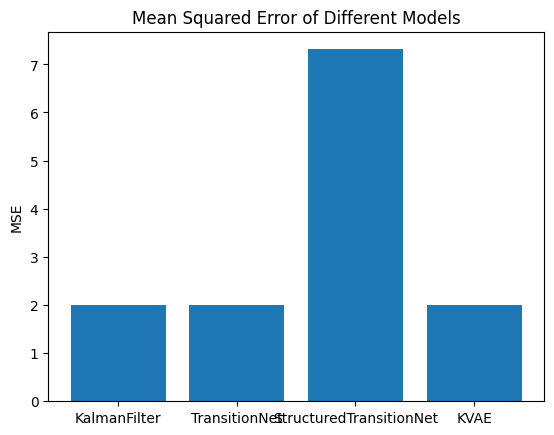

In [15]:
errors = {}
for model in models_list:
    est = ests[model]
    mse = np.mean((est[:, :2] - gt[:, :2])**2)
    errors[type(model).__name__] = mse

plt.bar(errors.keys(), errors.values())
plt.title("Mean Squared Error of Different Models")
plt.ylabel("MSE")
plt.show()